[View in Colaboratory](https://colab.research.google.com/github/anilsrik/algotrades/blob/master/EPAT.ipynb)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import numpy as np
from statsmodels.tsa.tsatools import lagmat
from numpy.linalg import inv
from statsmodels.tsa.coint_tables import c_sja, c_sjt

def coint_johansen_1(endog, det_order, k_ar_diff):
    """
    Perform the Johansen cointegration test for determining the cointegration
    rank of a VECM.
    Parameters
    ----------
    endog : array-like (nobs_tot x neqs)
        The data with presample.
    det_order : int
        * -1 - no deterministic terms
        * 0 - constant term
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
    Returns
    -------
    result : Holder
        An object containing the results which can be accessed using
        dot-notation. The object's attributes are
        * eig: (neqs)
          Eigenvalues.
        * evec: (neqs x neqs)
          Eigenvectors.
        * lr1: (neqs)
          Trace statistic.
        * lr2: (neqs)
          Maximum eigenvalue statistic.
        * cvt: (neqs x 3)
          Critical values (90%, 95%, 99%) for trace statistic.
        * cvm: (neqs x 3)
          Critical values (90%, 95%, 99%) for maximum eigenvalue
          statistic.
        * method: str
          "johansen"
        * r0t: (nobs x neqs)
          Residuals for :math:`\\Delta Y`. See p. 292 in [1]_.
        * rkt: (nobs x neqs)
          Residuals for :math:`Y_{-1}`. See p. 292 in [1]_.
        * ind: (neqs)
          Order of eigenvalues.
    Notes
    -----
    The implementation might change to make more use of the existing VECM
    framework.
    References
    ----------
    .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.
    """
    import warnings
    if det_order not in [-1, 0, 1]:
        warnings.warn("Critical values are only available for a det_order of "
                      "-1, 0, or 1.", category=HypothesisTestWarning)
    if endog.shape[1] > 12:  # todo: test with a time series of 13 variables
        warnings.warn("Critical values are only available for time series "
                      "with 12 variables at most.",
                      category=HypothesisTestWarning)

    from statsmodels.regression.linear_model import OLS

    class Holder(object):
        pass

    def detrend(y, order):
        if order == -1:
            return y
        return OLS(y, np.vander(np.linspace(-1, 1, len(y)),
                                order+1)).fit().resid

    def resid(y, x):
        if x.size == 0:
            return y
        r = y - np.dot(x, np.dot(np.linalg.pinv(x), y))
        return r

    nobs, neqs = endog.shape

    # why this?  f is detrend transformed series, det_order is detrend data
    if det_order > -1:
        f = 0
    else:
        f = det_order

    endog = detrend(endog, det_order)
    dx = np.diff(endog, 1, axis=0)
    z = lagmat(dx, k_ar_diff)
    z = z[k_ar_diff:]
    z = detrend(z, f)

    dx = dx[k_ar_diff:]

    dx = detrend(dx, f)
    r0t = resid(dx, z)
    lx = endog[:-k_ar_diff]
    lx = lx[1:]
    dx = detrend(lx, f)
    rkt = resid(dx, z)  # level on lagged diffs
    skk = np.dot(rkt.T, rkt) / rkt.shape[0]
    sk0 = np.dot(rkt.T, r0t) / rkt.shape[0]
    s00 = np.dot(r0t.T, r0t) / r0t.shape[0]
    sig = np.dot(sk0, np.dot(inv(s00), sk0.T))
    tmp = inv(skk)
    au, du = np.linalg.eig(np.dot(tmp, sig))  # au is eval, du is evec

    temp = inv(np.linalg.cholesky(np.dot(du.T, np.dot(skk, du))))
    dt = np.dot(du, temp)

    # JP: the next part can be done much  easier
    auind = np.argsort(au)
    aind = np.flipud(auind)
    a = au[aind]
    d = dt[:, aind]

    #  Compute the trace and max eigenvalue statistics
    lr1 = np.zeros(neqs)
    lr2 = np.zeros(neqs)
    cvm = np.zeros((neqs, 3))
    cvt = np.zeros((neqs, 3))
    iota = np.ones(neqs)
    t, junk = rkt.shape
    for i in range(0, neqs):
        tmp = np.log(iota - a)[i:]
        lr1[i] = -t * np.sum(tmp, 0)
        lr2[i] = -t * np.log(1-a[i])
        cvm[i, :] = c_sja(neqs - i, det_order)
        cvt[i, :] = c_sjt(neqs - i, det_order)
        aind[i] = i

    result = Holder()
    # estimation results, residuals
    result.rkt = rkt
    result.r0t = r0t
    result.eig = a
    result.evec = d
    result.lr1 = lr1
    result.lr2 = lr2
    result.cvt = cvt
    result.cvm = cvm
    result.ind = aind
    result.meth = 'johansen'

    return result


In [0]:
import statsmodels as sm
import statsmodels.api as smapi
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from statsmodels.regression.linear_model import OLS
tdiff = np.diff

ss_ejcp0 = '''\
         2.9762  4.1296  6.9406
         9.4748 11.2246 15.0923
        15.7175 17.7961 22.2519
        21.8370 24.1592 29.0609
        27.9160 30.4428 35.7359
        33.9271 36.6301 42.2333
        39.9085 42.7679 48.6606
        45.8930 48.8795 55.0335
        51.8528 54.9629 61.3449
        57.7954 61.0404 67.6415
        63.7248 67.0756 73.8856
        69.6513 73.0946 80.0937'''

ss_ejcp1 = '''\
         2.7055   3.8415   6.6349
        12.2971  14.2639  18.5200
        18.8928  21.1314  25.8650
        25.1236  27.5858  32.7172
        31.2379  33.8777  39.3693
        37.2786  40.0763  45.8662
        43.2947  46.2299  52.3069
        49.2855  52.3622  58.6634
        55.2412  58.4332  64.9960
        61.2041  64.5040  71.2525
        67.1307  70.5392  77.4877
        73.0563  76.5734  83.7105'''

ss_ejcp2 = '''\
         2.7055   3.8415   6.6349
        15.0006  17.1481  21.7465
        21.8731  24.2522  29.2631
        28.2398  30.8151  36.1930
        34.4202  37.1646  42.8612
        40.5244  43.4183  49.4095
        46.5583  49.5875  55.8171
        52.5858  55.7302  62.1741
        58.5316  61.8051  68.5030
        64.5292  67.9040  74.7434
        70.4630  73.9355  81.0678
        76.4081  79.9878  87.2395'''

ejcp0 = np.array(ss_ejcp0.split(),float).reshape(-1,3)
ejcp1 = np.array(ss_ejcp1.split(),float).reshape(-1,3)
ejcp2 = np.array(ss_ejcp2.split(),float).reshape(-1,3)

def c_sja(n, p):
    if ((p > 1) or (p < -1)):
        jc = np.zeros(3)
    elif ((n > 12) or (n < 1)):
        jc = np.zeros(3)
    elif p == -1:
        jc = ejcp0[n-1,:]
    elif p == 0:
        jc = ejcp1[n-1,:]
    elif p == 1:
        jc = ejcp2[n-1,:]

    return jc

ss_tjcp0 = '''\
         2.9762   4.1296   6.9406
        10.4741  12.3212  16.3640
        21.7781  24.2761  29.5147
        37.0339  40.1749  46.5716
        56.2839  60.0627  67.6367
        79.5329  83.9383  92.7136
       106.7351 111.7797 121.7375
       137.9954 143.6691 154.7977
       173.2292 179.5199 191.8122
       212.4721 219.4051 232.8291
       255.6732 263.2603 277.9962
       302.9054 311.1288 326.9716'''


ss_tjcp1 = '''\
          2.7055   3.8415   6.6349
         13.4294  15.4943  19.9349
         27.0669  29.7961  35.4628
         44.4929  47.8545  54.6815
         65.8202  69.8189  77.8202
         91.1090  95.7542 104.9637
        120.3673 125.6185 135.9825
        153.6341 159.5290 171.0905
        190.8714 197.3772 210.0366
        232.1030 239.2468 253.2526
        277.3740 285.1402 300.2821
        326.5354 334.9795 351.2150'''

ss_tjcp2 = '''\
           2.7055   3.8415   6.6349
          16.1619  18.3985  23.1485
          32.0645  35.0116  41.0815
          51.6492  55.2459  62.5202
          75.1027  79.3422  87.7748
         102.4674 107.3429 116.9829
         133.7852 139.2780 150.0778
         169.0618 175.1584 187.1891
         208.3582 215.1268 228.2226
         251.6293 259.0267 273.3838
         298.8836 306.8988 322.4264
         350.1125 358.7190 375.3203'''

tjcp0 = np.array(ss_tjcp0.split(),float).reshape(-1,3)
tjcp1 = np.array(ss_tjcp1.split(),float).reshape(-1,3)
tjcp2 = np.array(ss_tjcp2.split(),float).reshape(-1,3)

def c_sjt(n, p):
    if ((p > 1) or (p < -1)):
        jc = np.zeros(3)
    elif ((n > 12) or (n < 1)):
        jc = np.zeros(3)
    elif p == -1:
        jc = tjcp0[n-1,:]
    elif p == 0:
        jc = tjcp1[n-1,:]
    elif p == 1:
        jc = tjcp2[n-1,:]
    else:
        raise ValueError('invalid p')

    return jc


class Holder(object):
    pass

def rows(x):
    return x.shape[0]

def trimr(x, front, end):
    if end > 0:
        return x[front:-end]
    else:
        return x[front:]

import statsmodels.tsa.tsatools as tsat
mlag = tsat.lagmat

def mlag_(x, maxlag):
    '''return all lags up to maxlag
    '''
    return x[:-lag]

def lag(x, lag):
    return x[:-lag]

def detrend(y, order):
    if order == -1:
        return y
    return OLS(y, np.vander(np.linspace(-1,1,len(y)), order+1)).fit().resid

def resid(y, x):
    if x.size == 0:
        return y
    try:
        r = y - np.dot(x, np.dot(np.linalg.pinv(x), y))
    except:
        return None
    return r


def coint_johansen(x, p, k, coint_trend=None):

    #    % error checking on inputs
    #    if (nargin ~= 3)
    #     error('Wrong # of inputs to johansen')
    #    end
    nobs, m = x.shape

    #why this?  f is detrend transformed series, p is detrend data
    if (p > -1):
        f = 0
    else:
        f = p

    if coint_trend is not None:
        f = coint_trend  #matlab has separate options

    x     = detrend(x,p)
    dx    = tdiff(x,1, axis=0)
    #dx    = trimr(dx,1,0)
    z     = mlag(dx,k)#[k-1:]
    z = trimr(z,k,0)
    z     = detrend(z,f)
    dx = trimr(dx,k,0)

    dx    = detrend(dx,f)
    #r0t   = dx - z*(z\dx)
    r0t   = resid(dx, z)  #diff on lagged diffs
    #lx = trimr(lag(x,k),k,0)
    lx = lag(x,k)
    lx = trimr(lx, 1, 0)
    dx    = detrend(lx,f)
    #rkt   = dx - z*(z\dx)
    rkt   = resid(dx, z)  #level on lagged diffs
    if rkt is None:
        return None
    skk   = np.dot(rkt.T, rkt) / rows(rkt)
    sk0   = np.dot(rkt.T, r0t) / rows(rkt)
    s00   = np.dot(r0t.T, r0t) / rows(r0t)
    try:
        sig   = np.dot(sk0, np.dot(inv(s00), (sk0.T)))
    except:
        return None

    try:
        tmp   = inv(skk)
    except:
        return None
    
    #du, au = eig(np.dot(tmp, sig))
    au, du = eig(np.dot(tmp, sig))  #au is eval, du is evec
    #orig = np.dot(tmp, sig)
    try:
    #% Normalize the eigen vectors such that (du'skk*du) = I
        temp   = inv(chol(np.dot(du.T, np.dot(skk, du))))
    except:
        return None
    dt     = np.dot(du, temp)


    #JP: the next part can be done much  easier

    #%      NOTE: At this point, the eigenvectors are aligned by column. To
    #%            physically move the column elements using the MATLAB sort,
    #%            take the transpose to put the eigenvectors across the row

    #dt = transpose(dt)

    #% sort eigenvalues and vectors

    #au, auind = np.sort(diag(au))
    auind = np.argsort(au)
    #a = flipud(au)
    aind = flipud(auind)
    a = au[aind]
    #d = dt[aind,:]
    d = dt[:,aind]

    #%NOTE: The eigenvectors have been sorted by row based on auind and moved to array "d".
    #%      Put the eigenvectors back in column format after the sort by taking the
    #%      transpose of "d". Since the eigenvectors have been physically moved, there is
    #%      no need for aind at all. To preserve existing programming, aind is reset back to
    #%      1, 2, 3, ....

    #d  =  transpose(d)
    #test = np.dot(transpose(d), np.dot(skk, d))

    #%EXPLANATION:  The MATLAB sort function sorts from low to high. The flip realigns
    #%auind to go from the largest to the smallest eigenvalue (now aind). The original procedure
    #%physically moved the rows of dt (to d) based on the alignment in aind and then used
    #%aind as a column index to address the eigenvectors from high to low. This is a double
    #%sort. If you wanted to extract the eigenvector corresponding to the largest eigenvalue by,
    #%using aind as a reference, you would get the correct eigenvector, but with sorted
    #%coefficients and, therefore, any follow-on calculation would seem to be in error.
    #%If alternative programming methods are used to evaluate the eigenvalues, e.g. Frame method
    #%followed by a root extraction on the characteristic equation, then the roots can be
    #%quickly sorted. One by one, the corresponding eigenvectors can be generated. The resultant
    #%array can be operated on using the Cholesky transformation, which enables a unit
    #%diagonalization of skk. But nowhere along the way are the coefficients within the
    #%eigenvector array ever changed. The final value of the "beta" array using either method
    #%should be the same.


    #% Compute the trace and max eigenvalue statistics */
    lr1 = zeros(m)
    lr2 = zeros(m)
    cvm = zeros((m,3))
    cvt = zeros((m,3))
    iota = ones(m)
    t, junk = rkt.shape
    for i in range(0, m):
        tmp = trimr(np.log(iota-a), i ,0)
        lr1[i] = -t * np.sum(tmp, 0)  #columnsum ?
        #tmp = np.log(1-a)
        #lr1[i] = -t * np.sum(tmp[i:])
        lr2[i] = -t * np.log(1-a[i])
        cvm[i,:] = c_sja(m-i,p)
        cvt[i,:] = c_sjt(m-i,p)
        aind[i]  = i
    #end

    result = Holder()
    #% set up results structure
    #estimation results, residuals
    result.rkt = rkt
    result.r0t = r0t
    result.eig = a
    result.evec = d  #transposed compared to matlab ?
    result.lr1 = lr1
    result.lr2 = lr2
    result.cvt = cvt
    result.cvm = cvm
    result.ind = aind
    result.meth = 'johansen'

    return result



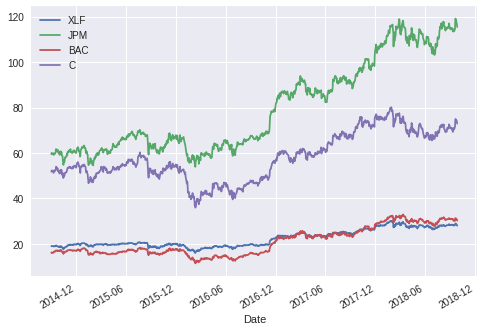

In [0]:
import pandas as pd
xlf = pd.read_csv("/content/gdrive/My Drive/EPAT/Data/XLF.csv", parse_dates=True, index_col="Date")
jpm = pd.read_csv("/content/gdrive/My Drive/EPAT/Data/JPM.csv", parse_dates=True, index_col="Date")
bac = pd.read_csv("/content/gdrive/My Drive/EPAT/Data/BAC.csv", parse_dates=True, index_col="Date")
c = pd.read_csv("/content/gdrive/My Drive/EPAT/Data/C.csv", parse_dates=True, index_col="Date")
#Merge to remove any missing data elements from each data frame. A data quality check.
df = xlf.merge(jpm, left_index=True, right_index=True, suffixes=('', "_jpm")).merge(bac,left_index=True,right_index=True,suffixes=("","_bac")).merge(c,left_index=True,right_index=True,suffixes=("","_c"))
series_df = df[["Open", "Open_jpm", "Open_bac", "Open_c"]].copy().rename(columns={"Open":"XLF", "Open_jpm":"JPM", "Open_bac":"BAC", "Open_c":"C"})
series_df.plot()

In [0]:
def get_johansen(y, p):
        """
        Get the cointegration vectors at 95% level of significance
        given by the trace statistic test.
        """

        N, l = y.shape
        jres = coint_johansen(y, 0, p)
        r = 0
        trstat = jres.lr1                       # trace statistic
        tsignf = jres.cvt                       # critical values

        for i in range(l):
            if trstat[i] > tsignf[i, 1]:     # 0: 90%  1:95% 2: 99%
                r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]

        return jres
      
coint_res = get_johansen(series_df,1)

In [0]:
coint_res.r

0